In [19]:
import pandas as pd
data=pd.read_csv('../input/tutu/changed data.csv')

In [20]:
data.iloc[4:10,:]

,Date,STI,HBAN,VIX,spread,splog,dowlog
4,2002-01-08,60.99,17.74,21.83,43.25,7.056787,7.628391
5,2002-01-09,61.80,17.64,22.13,44.16,7.051977,7.623099
6,2002-01-10,61.93,17.80,22.36,44.13,7.053197,7.624248
7,2002-01-11,61.59,17.72,22.60,43.87,7.043684,7.612070
8,2002-01-14,60.27,17.46,23.58,42.81,7.037388,7.596262
9,2002-01-15,61.02,17.83,22.70,43.19,7.044199,7.601357


In [21]:
data.set_index('Date',inplace=True)

In [22]:
data=data.fillna(1)

In [23]:
split=int(len(data.index)*0.85)
train=data.iloc[:split]
test=data.iloc[split:]

In [24]:
train.iloc[4:10,:]

,STI,HBAN,VIX,spread,splog,dowlog
Date,,,,,,
2002-01-08,60.99,17.74,21.83,43.25,7.056787,7.628391
2002-01-09,61.80,17.64,22.13,44.16,7.051977,7.623099
2002-01-10,61.93,17.80,22.36,44.13,7.053197,7.624248
2002-01-11,61.59,17.72,22.60,43.87,7.043684,7.612070
2002-01-14,60.27,17.46,23.58,42.81,7.037388,7.596262
2002-01-15,61.02,17.83,22.70,43.19,7.044199,7.601357


In [25]:
train.head()

,STI,HBAN,VIX,spread,splog,dowlog
Date,,,,,,
2002-01-02,62.00,17.25,22.71,44.75,7.051570,7.590473
2002-01-03,62.30,17.45,21.34,44.85,7.060708,7.622796
2002-01-04,62.30,17.77,20.45,44.53,7.066902,7.630160
2002-01-07,62.38,17.71,21.94,44.67,7.060382,7.619283
2002-01-08,60.99,17.74,21.83,43.25,7.056787,7.628391


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

In [27]:
train.tail()

,STI,HBAN,VIX,spread,splog,dowlog
Date,,,,,,
2017-01-10,55.70,13.33,11.49,42.37,7.727050,8.621881
2017-01-11,56.03,13.44,11.26,42.59,7.729876,8.624010
2017-01-12,55.49,13.32,11.54,42.17,7.727729,8.621101
2017-01-13,55.97,13.47,11.23,42.50,7.729577,8.625890
2017-01-17,53.88,12.95,11.87,40.93,7.726605,8.619521


In [28]:
def getState(t, data=train, window=30):
    if t - window >= -1:
        vec = data.iloc[t - window + 1:t + 1,:].to_numpy()
    else: 
        x = np.tile(data.iloc[0,:].to_numpy(), (window-t-1, 1))
        y = data.iloc[0: t + 1,:].to_numpy()
        vec = np.vstack((x,y))
    return vec

In [29]:

class Simulator(object):

    def __init__(self, data,data_out):

        # frame a time period as worl
        # initialize cash holdings
        init_cash = 100000

        #for visualization
        #self.data_out = data_out

        self.data_out=data_out
        # first trading day
        self.dateIdx = 0
        #self.date = start_date
        #self.start_date = start_date
        #self.end_date = end_date

        self.data = data
        #self.stockA = data['STI']
        #self.stockB = data['HBAN']

        # keep track of portfolio value as a series
        self.portfolio = {'cash': init_cash, 'a_vol': [], 'a_price': [], 'b_vol': [], 'b_price': [], 'longA': 0}
        self.port_val = 100000

        
    def init_state(self):
        """
        return init states of the market
        """
        states = getState(0)
        self.dateIdx =0
        return states

    def step(self, action):

        buy_volume = 100
    
        if (action == 1):#buy
            if (self.portfolio['longA'] >= 0):

                
                long_cost = buy_volume * self.data.iloc[self.dateIdx,0]

                short_cost = buy_volume * self.data.iloc[self.dateIdx,1]

                total_cost = short_cost + long_cost

                self.portfolio['cash'] -= total_cost

                
                self.portfolio['a_vol'].append(buy_volume)
                self.portfolio['a_price'].append(self.data.iloc[self.dateIdx,0])
                self.portfolio['b_vol'].append(buy_volume)
                self.portfolio['b_price'].append(self.data.iloc[self.dateIdx,1])
                self.portfolio['longA'] = 1

                
                old_port_val = self.port_val
                self.port_val = self.port_value_for_output()

                reward = self.port_val - old_port_val
                

            else: #longA < 0 --> sell in reverse
                long_return = self.portfolio['b_vol'].pop(0) * self.data.iloc[self.dateIdx,1]              
                self.portfolio['b_price'].pop(0)
            
                short_return = self.portfolio['a_vol'][0] * self.portfolio['a_price'][0]
                short_return += (self.portfolio['a_vol'].pop(0) * (self.portfolio['a_price'].pop(0) -self.data.iloc[self.dateIdx,0]))

                
                new_cash = self.portfolio['cash'] + long_return + short_return
                self.portfolio['cash'] = new_cash
                self.portfolio['longA'] = -1 if (len(self.portfolio['a_vol']) > 0) else 0
                old_port_val = self.port_val
                self.port_val = self.port_value_for_output()
                reward = self.port_val - old_port_val
                
        elif (action == 2): #sell
            if (self.portfolio['longA'] > 0):
                long_return = self.portfolio['a_vol'].pop(0) *self.data.iloc[self.dateIdx,0] 
                self.portfolio['a_price'].pop(0)
                
                short_return = self.portfolio['b_vol'][0] * self.portfolio['b_price'][0]
                short_return += (self.portfolio['b_vol'].pop(0) * (self.portfolio['b_price'].pop(0) -self.data.iloc[self.dateIdx,1]))
                
                new_cash = self.portfolio['cash'] + long_return + short_return
                self.portfolio['cash'] = new_cash
                self.portfolio['longA'] = 1 if (len(self.portfolio['a_vol']) > 0) else 0
                old_port_val = self.port_val
                self.port_val = self.port_value_for_output()
                reward = self.port_val - old_port_val
            else: # longA <= 0 --> buy in reverse
                
                long_cost = buy_volume * self.data.iloc[self.dateIdx,0]
                short_cost = buy_volume * self.data.iloc[self.dateIdx,1]
                total_cost = short_cost + long_cost
                self.portfolio['cash'] -= total_cost
                self.portfolio['a_vol'].append(buy_volume)
                self.portfolio['a_price'].append(self.data.iloc[self.dateIdx,0])
                self.portfolio['b_vol'].append(buy_volume)
                self.portfolio['b_price'].append(-self.data.iloc[self.dateIdx,1])
                self.portfolio['longA'] = -1
                old_port_val = self.port_val
                self.port_val = self.port_value_for_output()
                reward = self.port_val - old_port_val
                
        else: #hold    
            old_port_val = self.port_val
            self.port_val = self.port_value_for_output()
            reward = self.port_val - old_port_val
        
        self.data_out.append([self.port_val/100000-1,self.port_val])
        self.dateIdx += 1
        state = getState(self.dateIdx)

        if self.dateIdx < len(self.data.index)-1:
            done=False
        else:
            done =True
            print(self.port_val)
        return (state, reward, done)

    
    # alternate calculation of the current value of cash and stock holdings
    def port_value_for_output(self):
        value = self.portfolio['cash']
        if (self.portfolio['longA'] > 0):
            value += (sum(self.portfolio['a_vol']) * self.data.iloc[self.dateIdx,0])
            for i in range(len(self.portfolio['b_vol'])):
                value += (self.portfolio['b_vol'][i] * self.portfolio['b_price'][i])
                value += (self.portfolio['b_vol'][i] * (self.portfolio['b_price'][i] - self.data.iloc[self.dateIdx,1]))
        if (self.portfolio['longA'] < 0):
            value += (sum(self.portfolio['b_vol']) * self.data.iloc[self.dateIdx,1])
            for i in range(len(self.portfolio['a_vol'])):
                value += (self.portfolio['a_vol'][i] * self.portfolio['a_price'][i])
                value += (self.portfolio['a_vol'][i] * (self.portfolio['a_price'][i] - self.data.iloc[self.dateIdx,0]))
        return value



In [30]:
LR_A = 0.001    # learning rate for actor
LR_C = 0.002    # learning rate for critic
GAMMA = 0.9     # reward discount
TAU = 0.01      # soft replacement
MEMORY_CAPACITY = 100
BATCH_SIZE = 30
TAU = 0.01

In [31]:
class Actor(nn.Module):   # ae(s)=a
    def __init__(self,s_dim,a_dim):
        super(Actor,self).__init__()
        
        self.fc1=torch.nn.LSTM(
            input_size=s_dim,
            hidden_size=20,
            dropout=0.2,
            num_layers=2)
        #self.fc1.weight.data.normal_(0,0.1) # initialization
        self.out = nn.Linear(20,a_dim)
        #self.out.weight.data.normal_(0,0.1) # initialization
    def forward(self,x):
        x=np.expand_dims(x,1)
        x=Variable(torch.from_numpy(x)).float().cuda()
        #x= torch.unsqueeze(x, 1)
        #print(x.size())
        output,(h_n,c_n)=self.fc1(x)
        #print(output.size(),1)
        output_in_last_timestep=output[-1] # many to one
        #print(output_in_last_timestep.size())
        s=torch.squeeze(output_in_last_timestep,1)
        #print(s.size(),2)
        x=self.out(s)
        actions_value = F.softmax(x,dim=-1)
        #print(actions_value,2.5)
        return actions_value
          

In [32]:
class Critic(nn.Module):   # ae(s)=a
    def __init__(self,s_dim,a_dim):
        super(Critic,self).__init__()
        self.fcs=torch.nn.LSTM(
            input_size=s_dim,
            hidden_size=20,
            dropout=0.2,
            num_layers=1,
            bidirectional=True)
        #self.fcs.weight.data.normal_(0,0.1) # initialization
        self.fca = nn.Linear(a_dim,20*2)
        self.fca.weight.data.normal_(0,0.1) # initialization
        self.out = nn.Linear(20*2,1)
        self.out.weight.data.normal_(0, 0.1)  # initialization
    def forward(self,s,a):
        s=np.expand_dims(s,1)
        s=Variable(torch.from_numpy(s)).float().cuda()
        #s= torch.unsqueeze(s, 1)
        #print(s.size())
        output,(h_n,c_n)=self.fcs(s)
        #print(output.size())
        output_in_last_timestep=output[-1] # many to one
        #print(output_in_last_timestep.size())
        s=torch.squeeze(output_in_last_timestep,1)
        
        a=Variable(torch.from_numpy(a)).float().cuda()
        y = self.fca(a)
        net = F.relu(s+y)
        state_value = self.out(net)
        #print(state_value.shape)
        return state_value


In [33]:
class DDPG(object):
    def __init__(self, a_dim, s_dim):
        self.a_dim, self.s_dim= a_dim, s_dim
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        #self.sess = tf.Session()
        self.Actor_eval = Actor(s_dim,a_dim).cuda()
        self.Actor_target = Actor(s_dim,a_dim).cuda()
        self.Critic_eval = Critic(s_dim,a_dim).cuda()
        self.Critic_target = Critic(s_dim,a_dim).cuda()
        self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr=LR_C)
        self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr=LR_A)
        self.loss_td = nn.MSELoss()

    def choose_action(self, s):
        #print(self.Actor_eval(s),4)
        return self.Actor_eval(s).detach().cpu().clone().numpy()  # ae（s）

    def learn(self):

        for x in self.Actor_target.state_dict().keys():
            eval('self.Actor_target.' + x + '.data.mul_((1-TAU))')
            eval('self.Actor_target.' + x + '.data.add_(TAU*self.Actor_eval.' + x + '.data)')
        for x in self.Critic_target.state_dict().keys():
            eval('self.Critic_target.' + x + '.data.mul_((1-TAU))')
            eval('self.Critic_target.' + x + '.data.add_(TAU*self.Critic_eval.' + x + '.data)')

        # soft target replacement
        #self.sess.run(self.soft_replace)  # 用ae、ce更新at，ct

        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = torch.FloatTensor(bt[:, -self.s_dim - 1: -self.s_dim])
        bs_ = bt[:, -self.s_dim:]

        a = self.Actor_eval(bs).detach().cpu().clone().numpy()
        q = self.Critic_eval(bs,a)  # loss=-q=-ce（s,ae（s））更新ae   ae（s）=a   ae（s_）=a_

        loss_a = -torch.mean(q) 
        #print(q)
        #print(loss_a)
        self.atrain.zero_grad()
        loss_a.backward()
        self.atrain.step()

        a_ = self.Actor_target(bs_).detach().cpu().clone().numpy()  
        q_ = self.Critic_target(bs_,a_)
        q_target = br+GAMMA*q_.cpu()  # q_target = 负的
        #print(q_target)
        q_v = self.Critic_eval(bs,ba).cpu()
        #print(q_v)
        td_error = self.loss_td(q_target,q_v)
        # td_error=R + GAMMA * ct（bs_,at(bs_)）-ce(s,ba) 更新ce ,但这个ae(s)是记忆中的ba，让ce得出的Q靠近Q_target,让评价更准确
        #print(td_error)
        self.ctrain.zero_grad()
        td_error.backward()
        self.ctrain.step()

    def store_transition(self, s, a, r, s_):
        #transition = np.hstack((s[-1], a, [r], s_[-1]))
        #print(s.size(),a,r)
        transition = np.zeros(self.s_dim * 2 + self.a_dim + 1)
        transition[:self.s_dim]=s[-1]
        transition[self.s_dim: self.s_dim + self.a_dim]=a
        transition[-self.s_dim - 1: -self.s_dim]=r
        transition[-self.s_dim:]=s_[-1]
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1



In [34]:
s_dim=6
a_dim=3
ddpg=DDPG(a_dim,s_dim)
EPSILON_DECAY = 1
MAX_EPISODES = 20
#MAX_EP_STEPS = len(data.index)
data_out=[]
#start_date=data.index[0]
#end_date=data.index[1]
actions=['buy','sell','hold']

In [35]:
class OrnsteinUhlenbeckActionNoise(object):
    def __init__(self, mu=np.zeros(3), sigma=0.2, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)


In [36]:
for i in range(30):

    Finance=Simulator(train,data_out)
    s = Finance.init_state()
    ep_reward = 0
    done = False
    noise=OrnsteinUhlenbeckActionNoise(np.zeros(3))
    #for j in range(MAX_EP_STEPS-1):
    while (done==False):
        # Add exploration noise
        a = ddpg.choose_action(s)
        random=noise.__call__()
        a = a+EPSILON_DECAY*random
        a/=a.sum()
        a = np.clip(a,0,1)
        a/=a.sum()
        a = np.random.choice(3,p=a[0,:])
        action=a
        s_, r, done = Finance.step(action)

        ddpg.store_transition(s, a, r, s_)

        if ddpg.pointer > MEMORY_CAPACITY:
            EPSILON_DECAY *= .9995    # decay the action randomness
            noise.reset()
            ddpg.learn()

        s = s_
        ep_reward += r
        #if done == True:
        if done == True:
            print('Episode:', i, ' Reward: %i' % int(ep_reward))
        

475055.0
Episode: 0  Reward: 375055
397998.0
Episode: 1  Reward: 297998
362336.0
Episode: 2  Reward: 262336
473243.0
Episode: 3  Reward: 373243
399428.0
Episode: 4  Reward: 299428
493252.0
Episode: 5  Reward: 393252
522724.0
Episode: 6  Reward: 422724
403508.0
Episode: 7  Reward: 303508
357798.0
Episode: 8  Reward: 257798
450553.0
Episode: 9  Reward: 350553
570142.0
Episode: 10  Reward: 470142
511521.0
Episode: 11  Reward: 411521
461883.0
Episode: 12  Reward: 361883
529775.0
Episode: 13  Reward: 429775
401341.0
Episode: 14  Reward: 301341
400556.0
Episode: 15  Reward: 300556
369796.0
Episode: 16  Reward: 269796
352560.0
Episode: 17  Reward: 252560
476142.0
Episode: 18  Reward: 376142
444951.0
Episode: 19  Reward: 344951
302449.0
Episode: 20  Reward: 202449
605082.0
Episode: 21  Reward: 505082
388611.0
Episode: 22  Reward: 288611
441121.0
Episode: 23  Reward: 341121
388053.0
Episode: 24  Reward: 288053
561350.0
Episode: 25  Reward: 461350
475786.0
Episode: 26  Reward: 375786
527722.0
Ep

In [37]:
pct_change=[]
profit=[]
for i in range(len(data_out)):
    pct_change.append(data_out[i][0])
    profit.append(data_out[i][1])

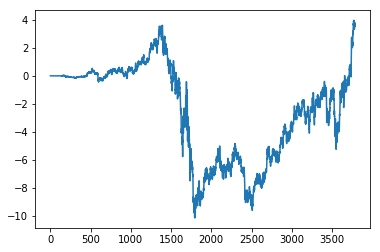

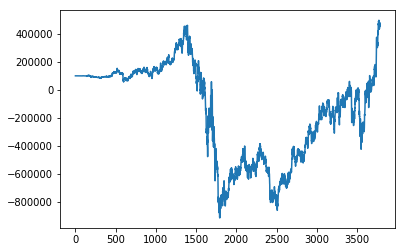

In [39]:
import matplotlib.pyplot as plt
l=len(train.index)-1
plt.figure()
plt.plot(range(l-1),pct_change[:l-1])
#plt.subplot(122)
plt.figure()
plt.plot(range(l-1),profit[:l-1])
plt.show()

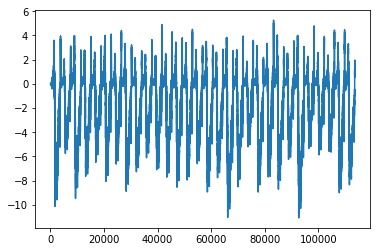

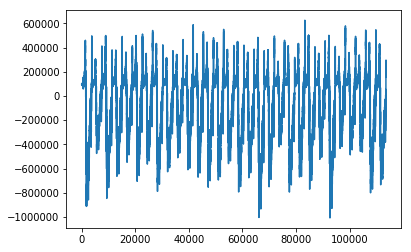

In [40]:
plt.figure()
plt.plot(pct_change)
#plt.subplot(122)
plt.figure()
plt.plot(profit)
plt.show()

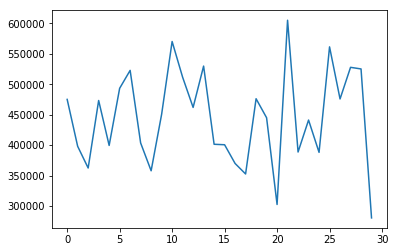

In [42]:
plt.figure()
plt.plot(a)
plt.show()

In [44]:
    predict=[]
    Finance=Simulator(test,predict)
    s = Finance.init_state()
    ep_reward = 0
    done = False
    #noise=OrnsteinUhlenbeckActionNoise(np.zeros(3))
    #for j in range(MAX_EP_STEPS-1):
    while (done==False):
        # Add exploration noise
        a = ddpg.choose_action(s)
        #random=noise.__call__()
        #a = a+EPSILON_DECAY*random
        #a/=a.sum()
        #a = np.clip(a,0,1)
        #a/=a.sum()
        a = np.argmax(a)
        action=a
        s_, r, done = Finance.step(action)

        ddpg.store_transition(s, a, r, s_)

        if ddpg.pointer > MEMORY_CAPACITY:
            #EPSILON_DECAY *= .9995    # decay the action randomness
            #noise.reset()
            ddpg.learn()

        s = s_
        ep_reward += r
        #if done == True:
        if done == True:
            print('Episode:', i, ' Reward: %i' % int(ep_reward))
        

441188.0
Episode: 113579  Reward: 341188


In [45]:
pct_change_=[]
profit_=[]
for i in range(len(predict)):
    pct_change_.append(predict[i][0])
    profit_.append(predict[i][1])

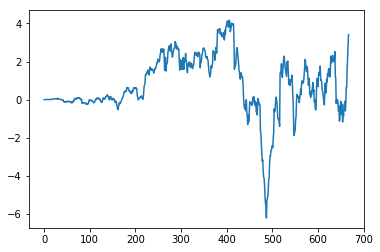

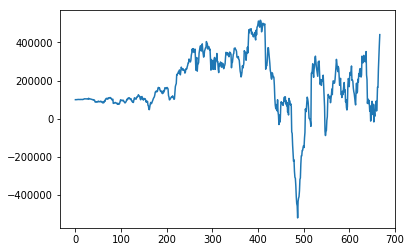

In [46]:
plt.figure()
plt.plot(pct_change_)
#plt.subplot(122)
plt.figure()
plt.plot(profit_)
plt.show()